## Importando Libraries

In [105]:
import pandas as pd

## Criando Data Frames Iniciais

In [106]:
cards_status= pd.read_csv('../data/Sources/cards_status.csv')


cards_transactions = pd.read_csv('../data/Sources/cards_transactions.csv')


In [107]:
cards = pd.read_csv('../data/Sources/cards.csv')

### Funções Auxiliares

### Fazendo Ajustes de Colunas

In [292]:
# Converter para datetime (caso ainda não tenha feito)
cards_status['started_at'] = pd.to_datetime(cards_status['started_at'])
cards_status['ended_at'] = pd.to_datetime(cards_status['ended_at'], errors='coerce')



# Função para extrair a data de início do trimestre, lidando com NaT
def get_quarter_start(date):
    if pd.isna(date):  # Se a data for NaT, retorna NaT
        return pd.NaT
    return date.to_period("Q").start_time  # Retorna o primeiro dia do trimestre

# Aplicando a função de forma segura
cards_status['quarter_start'] = cards_status['started_at'].apply(get_quarter_start)
cards_status['quarter_end'] = cards_status['ended_at'].apply(get_quarter_start)  # Evita erro com NaT

# Atribuindo um valor para cada status
status_dict = {'PERMANENTLY_TERMINATED': 1, 'TEMPORARILY_BLOCKED': 0, 'OPEN': -1}

# Mapear o status para o valor correspondente
cards_status['status_value'] = cards_status['card_status'].map(status_dict)


In [247]:
# Converter valid_thru para datetime (último dia do mês)
cards["valid_thru"] = pd.to_datetime(cards["valid_thru"], format="%m/%y") + pd.offsets.MonthEnd(0)

# Obter o primeiro dia do trimestre correspondente
cards["valid_quarter_start"] = cards["valid_thru"].dt.to_period("Q").apply(lambda x: x.start_time)

In [110]:
# Converter transaction_date para datetime
cards_transactions["transaction_date"] = pd.to_datetime(cards_transactions["transaction_date"])

# Obter o último dia do mês da transação
cards_transactions["valid_thru"] = cards_transactions["transaction_date"] + pd.offsets.MonthEnd(0)

# Obter o primeiro dia do trimestre correspondente
cards_transactions["quarter_start"] = cards_transactions["valid_thru"].dt.to_period("Q").apply(lambda x: x.start_time)


C:\Users\theo.lourencao_ifood\AppData\Local\Temp\ipykernel_1560\74604042.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cards_transactions["quarter_start"] = cards_transactions["valid_thru"].dt.to_period("Q").apply(lambda x: x.start_time)


Agora vamos fazer o tratamento de dados para que possamos responder as perguntas de negócio

Teremos que sempre considerar que: Os status serão analisados através de cada intervalo

A ideia é construir os valores de ativos no início de um ciclo de forma independente dos ativos no final, para garantir que as volumetrias se conversam

### Definindo Janelas de Tempo de cada trimestre

In [111]:
quarters_dates = {
    'Q1': {'start': '2023-01-01', 'end': '2023-03-31'},
    'Q2': {'start': '2023-04-01', 'end': '2023-06-30'},
    'Q3': {'start': '2023-07-01', 'end': '2023-09-30'},
    'Q4': {'start': '2023-10-01', 'end': '2023-12-31'}
}

## Construindo a Lógica de Ativos no **Início** de Cada Quarter

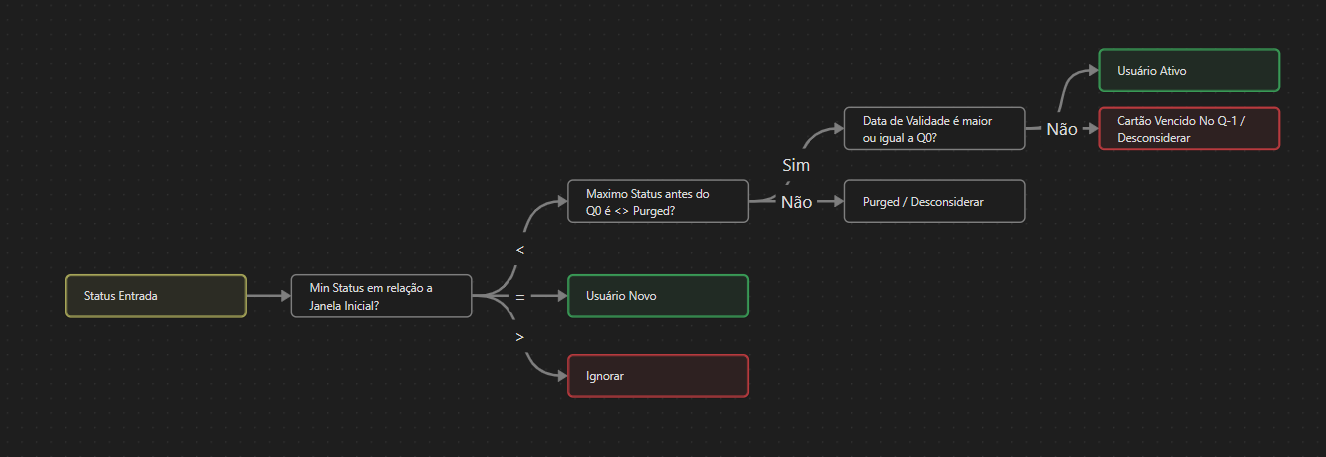

### Primeiro Evento de Status

In [ ]:
# Para cada cartão, pegar a primeira ocorrência baseada na menor data de 'started_at'
first_idx = cards_status.groupby('card_number')['started_at'].idxmin()

# Selecionar todas as colunas correspondentes ao primeiro evento de cada cartão
card_first_status = cards_status.loc[first_idx].reset_index(drop=True)



### Data de Término do Cartão

In [113]:
terminated_cards = cards_status[cards_status['card_status'] == 'PERMANENTLY_TERMINATED']

## Validações Intermediárias

In [114]:
terminated_cards[terminated_cards['card_number'] == 150203565]

,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end
3,150203565,PIN,PLASTIC,PERMANENTLY_TERMINATED,2023-03-03,NaT,2023-01-01,NaT


In [115]:
card_first_status[card_first_status['card_number'] == 150203565]

,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end
9146,150203565,PIN,PLASTIC,OPEN,2022-12-14,2023-03-03,2022-10-01,2023-01-01


In [116]:
cards_status[cards_status['card_number'] == 150203565]

,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end
3,150203565,PIN,PLASTIC,PERMANENTLY_TERMINATED,2023-03-03,NaT,2023-01-01,NaT
4,150203565,PIN,PLASTIC,OPEN,2022-12-14,2023-03-03,2022-10-01,2023-01-01


## Agregando Existentes na Base

In [282]:
granular_data = []

for q in quarters_dates:

    
    start = quarters_dates[q]['start']
    end = quarters_dates[q]['end']

    # Seleciona os cartões ativos antes do início do trimestre (MANTÉM TODAS AS COLUNAS)
    pre_existing_cards = card_first_status[card_first_status['quarter_start'] <= start]

    # Seleciona os cartões que já foram terminados antes do início do trimestre
    pre_terminated_cards = terminated_cards[(terminated_cards['started_at'] < start) | (terminated_cards['ended_at'] < start)][['card_number']]

    # Left anti join: mantém apenas os cartões que NÃO aparecem na tabela de terminados
    pre_existing_cards = pre_existing_cards.merge(pre_terminated_cards, on='card_number', how='left', indicator=True)

    display(pre_existing_cards[pre_existing_cards['card_number'] == 150203565])

    # Filtramos mantendo todas as colunas
    pre_existing_cards = pre_existing_cards[pre_existing_cards['_merge'] == 'left_only'].drop(columns=['_merge'])

        # Adiciona a informação do trimestre
    pre_existing_cards['quarter'] = q

    pre_existing_cards["iteration_quarter_start"] = start
    pre_existing_cards["iteration_quarter_end"] = end

    # Adiciona os dados granulares
    granular_data.append(pre_existing_cards)

# Concatena todos os dados granulares em um único DataFrame
quarter_existing_cards = pd.concat(granular_data, ignore_index=True)

# Agora, resume os dados por trimestre
summary_existing_cards = quarter_existing_cards.groupby('quarter')['card_number'].nunique().reset_index()

# Renomear as colunas para clareza
summary_existing_cards.columns = ['quarter', 'Starting_Cards']


,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end,_merge
9122,150203565,PIN,PLASTIC,OPEN,2022-12-14,2023-03-03,2022-10-01,2023-01-01,left_only


,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end,_merge
9135,150203565,PIN,PLASTIC,OPEN,2022-12-14,2023-03-03,2022-10-01,2023-01-01,both


,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end,_merge
9145,150203565,PIN,PLASTIC,OPEN,2022-12-14,2023-03-03,2022-10-01,2023-01-01,both


,card_number,card_model,card_type,card_status,started_at,ended_at,quarter_start,quarter_end,_merge
9146,150203565,PIN,PLASTIC,OPEN,2022-12-14,2023-03-03,2022-10-01,2023-01-01,both


## Construindo a Lógica de Ativos no **Final** de Cada Quarter

### Fluxo

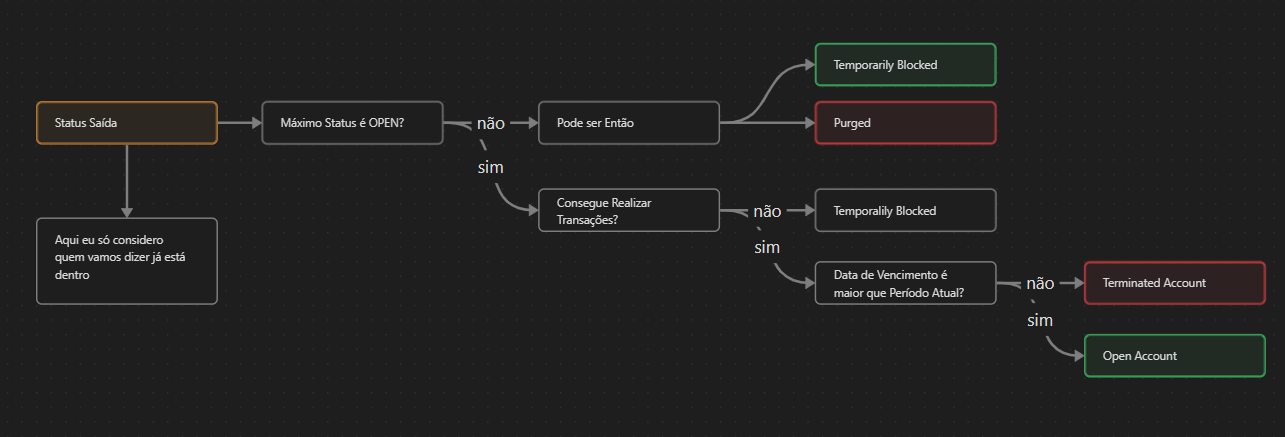

### Desenvolvimento

### Most Recent Status Before Quarter

In [338]:
granular_data = []

for quarter, dates in quarters_dates.items():
    start_date = pd.to_datetime(dates['start'])
    end_date = pd.to_datetime(dates['end'])
    
    # Seleciona os cartões ativos no trimestre
    active_cards_in_quarter = quarter_existing_cards[
        quarter_existing_cards['quarter'] == quarter
    ][["card_number"]].copy()
    
    # Obtém o status mais recente antes do trimestre
    latest_status_before_quarter = cards_status[cards_status['started_at'] < start_date]
    latest_status_before_quarter = latest_status_before_quarter.sort_values(
        by=['card_number', 'started_at'], ascending=[True, False]
    )
    latest_status_before_quarter = latest_status_before_quarter.drop_duplicates(
        subset=['card_number'], keep='first'
    )
    
    # Renomeia a coluna de status para tornar mais claro
    latest_status_before_quarter = latest_status_before_quarter.rename(
        columns={"card_status": "previous_quarter_last_status"}
    )
    
    # Junta os cartões com os status anteriores
    active_cards_in_quarter = active_cards_in_quarter.merge(
        latest_status_before_quarter[["card_number", "previous_quarter_last_status"]],
        on="card_number",
        how="left"
    )
    
    # Adiciona a data do início do trimestre
    active_cards_in_quarter["quarter_start_date"] = start_date
    
    # Mantém apenas as colunas necessárias
    active_cards_in_quarter = active_cards_in_quarter[["card_number", "previous_quarter_last_status", "quarter_start_date"]]
    
    granular_data.append(active_cards_in_quarter)

card_status_by_quarter = pd.concat(granular_data, ignore_index=True)


In [339]:
card_status_by_quarter

,card_number,previous_quarter_last_status,quarter_start_date
0,114602310,OPEN,2023-01-01
1,114602820,OPEN,2023-01-01
2,114605175,OPEN,2023-01-01
3,114607905,OPEN,2023-01-01
4,114613725,TEMPORARILY_BLOCKED,2023-01-01
...,...,...,...
953549,686696850,NaN,2023-10-01
953550,686710605,NaN,2023-10-01
953551,686722605,NaN,2023-10-01
953552,686740665,NaN,2023-10-01


#### Card Last Status By Quarter

In [332]:
import pandas as pd

granular_data = []

for q in quarters_dates:
    start = quarters_dates[q]['start']
    end = quarters_dates[q]['end']

    # Seleciona todos os cartões que estiveram ativos no trimestre
    current_quarter_existing_cards = quarter_existing_cards[quarter_existing_cards['quarter'] == q][["card_number"]].copy()

    # Adiciona os limites do trimestre
    current_quarter_existing_cards["iteration_quarter_start"] = start
    current_quarter_existing_cards["iteration_quarter_end"] = end

    # Filtra os status que estavam ativos no trimestre
    filtered_status = cards_status[
        (cards_status['started_at'] <= end)
    ].copy()

    # Faz o merge com os status
    most_recent_status = current_quarter_existing_cards.merge(
        filtered_status, on="card_number", how="left", validate="one_to_many"
    )

    # Ordena primeiro pelos critérios desejados
    most_recent_status = most_recent_status.sort_values(
        by=["card_number", "iteration_quarter_start", "started_at", "status_value"], 
        ascending=[True, True, False, False]
    )

    # Criar um ranking de status mais recente por cartão dentro do trimestre
    most_recent_status["rank"] = most_recent_status.groupby(["card_number", "iteration_quarter_start"]).cumcount()



    # Filtra apenas o status mais recente (rank 0)
    most_recent_status = most_recent_status[most_recent_status["rank"] == 0].drop(columns=["rank"])
    
    most_recent_status = most_recent_status[[
        "card_number", 
        "card_status",
        "iteration_quarter_start", 
        "iteration_quarter_end", 
        "status_value",  # Agora incluído
        "started_at"
    ]].rename(columns={"started_at": "most_recent_status_date"})

    granular_data.append(most_recent_status)

# Concatena todos os dados granulares em um único DataFrame
granular_data_df = pd.concat(granular_data, ignore_index=True)

# Ordena por iteration_quarter_start desc
quarter_last_status = granular_data_df.sort_values(by="iteration_quarter_start", ascending=False)


#### Cards Transactions By Quarter

In [295]:
# Aqui eu vou fazer um join para saber quem são os cartões que estão ativos no trimestre
# e que tiveram transações no trimestre

granular_data = []

for q in quarters_dates:

    start = quarters_dates[q]['start']
    end = quarters_dates[q]['end']

    # Seleciona os cartões ativos no trimestre
    current_quarter_existing_cards = quarter_existing_cards[quarter_existing_cards['quarter'] == q][["card_number"]].copy()

    # Adiciona os limites do trimestre
    current_quarter_existing_cards["iteration_quarter_start"] = pd.to_datetime(start)
    current_quarter_existing_cards["iteration_quarter_end"] = pd.to_datetime(end)
    
    current_quarter_transactions = current_quarter_existing_cards.merge(
      cards_transactions, 
      left_on=["card_number", "iteration_quarter_start"], 
      right_on=["card_number", "quarter_start"], 
      how="left", 
      validate="one_to_many"
    )

    card_transactions_by_quarter = current_quarter_transactions.groupby(["card_number", "iteration_quarter_start"]).agg(
        last_transaction_date=("transaction_date", "max"),
        first_transaction_date=("transaction_date", "min"),
        transaction_count=("transaction_id", "count"),
        total_amount=("amount", "sum")
    ).reset_index()

    card_transactions_by_quarter["iteration_quarter_start"] = card_transactions_by_quarter["iteration_quarter_start"].astype(str)

    granular_data.append(card_transactions_by_quarter)

    

card_transactions_by_quarter = pd.concat(granular_data, ignore_index=True)


### Consolidação

In [350]:
import pandas as pd

# Suponha que os DataFrames quarter_existing_cards, quarter_last_status, card_transactions_by_quarter, e cards estão corretamente definidos

# Certifique-se de que todas as colunas relevantes são datetime corretamente
quarter_existing_cards['iteration_quarter_start'] = pd.to_datetime(quarter_existing_cards['iteration_quarter_start'])
quarter_existing_cards['started_at'] = pd.to_datetime(quarter_existing_cards['started_at'])
quarter_last_status["iteration_quarter_start"] = pd.to_datetime(quarter_last_status['iteration_quarter_start'])
card_transactions_by_quarter['iteration_quarter_start'] = pd.to_datetime(card_transactions_by_quarter['iteration_quarter_start'])
card_status_by_quarter = card_status_by_quarter.rename(columns={"quarter_start_date": "iteration_quarter_start"})


# Passo 2: Identifica cartões existentes e novos
quarter_existing_cards_df = quarter_existing_cards[["card_number", "iteration_quarter_start", 'started_at']].copy()
quarter_existing_cards_df["aging"] = quarter_existing_cards_df.apply(
    lambda row: "retido" if row["iteration_quarter_start"] > row["started_at"] else "novo", axis=1
)

# Passo 3: Faz o UNION de existentes e novos
quarter_active_cards = quarter_existing_cards_df

# Passo 4: Junta com o status final
active_cards_status = quarter_active_cards.merge(
    quarter_last_status, 
    left_on=["card_number", "iteration_quarter_start"], 
    right_on=["card_number", "iteration_quarter_start"], 
    how="left"
)


# Join com tabelas adicionais
active_cards_status = active_cards_status.merge(card_transactions_by_quarter[['card_number','iteration_quarter_start','last_transaction_date','first_transaction_date','transaction_count','total_amount']], on=["card_number", "iteration_quarter_start"], how="left")


active_cards_status = active_cards_status.merge(cards, on=["card_number"], how="left")

#Remove casos em que a data de início do trimestre é maior que a data de expiração
active_cards_status = active_cards_status[active_cards_status['iteration_quarter_start'] <= active_cards_status['valid_thru']]

# Passo 5: Identifica cartões válidos
active_cards_status['is_valid'] = active_cards_status['valid_quarter_start'] > active_cards_status['iteration_quarter_start']
active_cards_status['has_orders'] = active_cards_status['total_amount'] > 0

active_cards_status = active_cards_status.merge(
    card_status_by_quarter, 
    on=["card_number", "iteration_quarter_start"], 
    how="left"
)

def determine_final_status(row):
    if  row['is_valid']==True and (row['card_status'] == 'TEMPORARILY_BLOCKED' or (row['card_status'] == 'OPEN' and row['total_amount'] == 0)):
        return 'TEMPORARILY_BLOCKED'
    elif not row['is_valid']:
        return 'Expired'
    elif row['card_status'] == 'OPEN' and row['total_amount'] > 0:
        return 'OPEN'
    else:
        return row['card_status']

# Aplicar a função ao DataFrame
active_cards_status['final_status'] = active_cards_status.apply(determine_final_status, axis=1)

# Mostrar resultado


In [355]:
## Adicionando a coluna 'quarter' ao DataFrame active_cards_status
active_cards_status['quarter'] = active_cards_status['iteration_quarter_start'].dt.to_period('Q').astype(str)

#fillna do quarter last status
active_cards_status['previous_quarter_last_status'] = active_cards_status['previous_quarter_last_status'].fillna('NEW')

## agrupamento por final_status, quarter, aging e has orders
quarter_grouped_statuses = active_cards_status.groupby(['final_status', 'quarter','card_status', 'aging', 'has_orders','card_model','previous_quarter_last_status']).size().reset_index(name='count')

## Exportando outputs

In [353]:
# Salvar o resultado em um arquivo CSV
active_cards_status.to_csv('../data/Output/active_cards_status.csv', index=False)




KeyboardInterrupt: 

In [356]:
# Salvar o resultado em um arquivo CSV
quarter_grouped_statuses.to_csv('../data/Output/quarter_grouped_statuses.csv', index=False)